# Green Trap Analysis

Use this notebook to explore clustering and machine learning analyses on the processed WDI features.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df = pd.read_csv('../data/processed/analysis_ready.csv')
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Country_Code                           299 non-null    object 
 1   Year                                   299 non-null    int64  
 2   FDI_Net_Inflows_Pct_GDP                299 non-null    float64
 3   Energy_Intensity                       299 non-null    float64
 4   Renewable_Electricity_Output_Pct       299 non-null    float64
 5   Renewable_Energy_Consumption_Pct       299 non-null    float64
 6   Net_Energy_Imports_Pct                 299 non-null    float64
 7   Alternative_Nuclear_Energy_Pct         299 non-null    float64
 8   Fossil_Fuel_Consumption_Pct            299 non-null    float64
 9   Energy_Use_Per_Capita                  299 non-null    float64
 10  Broad_Money_Pct_GDP                    299 non-null    float64
 11  CPI_In

In [16]:
if 'CO2_Emissions_Per_Capita' in df.columns:
    print("Column exists but was dropped later.")
else:
    print("Column was never created. Check your renaming step.")

Column was never created. Check your renaming step.


In [17]:
import pandas as pd
# Load your dataset again to see the raw names
# (Make sure 'WB_Data_All_Countries.csv' matches your actual file name in the data folder)
df_check = pd.read_csv('data/WB_Data_All_Countries.csv')

# Search for any column that looks like CO2
print("--- CO2 Columns Found ---")
for col in df_check.columns:
    if "CO2" in col:
        print(f"Raw Name: '{col}'")

FileNotFoundError: [Errno 2] No such file or directory: 'data/WB_Data_All_Countries.csv'

In [19]:
features_cluster = [
    'GDP_Growth',
    'FDI_Net_Inflows_Pct_GDP',
    'Energy_Intensity',
    'Renewable_Electricity_Output_Pct',
    'Renewable_Energy_Consumption_Pct',
    'Net_Energy_Imports_Pct',
    'Alternative_Nuclear_Energy_Pct',
    'Fossil_Fuel_Consumption_Pct',  # We are using this proxy now
    'Broad_Money_Pct_GDP',
    'CPI_Inflation',
    'Domestic_Credit_Pct_GDP',
    'Gov_Expenditure_Pct_GDP',
    'Gross_Fixed_Capital_Formation_Pct_GDP',
    'Trade_Pct_GDP'
]

print("Feature list updated manually.")
print("Does 'CO2' exist in list?", "CO2_Emissions_Per_Capita" in features_cluster)

Feature list updated manually.
Does 'CO2' exist in list? False


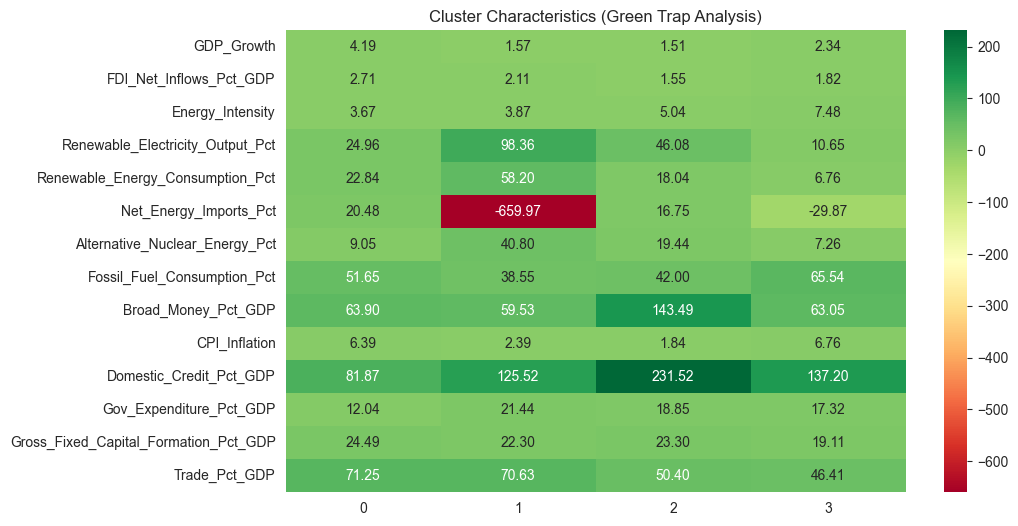

Turkey's Cluster History:
     Year  Cluster  CPI_Inflation  Renewable_Energy_Consumption_Pct
248  2019        0      15.176822                              14.1
249  2020        0      12.278957                              13.7
250  2021        0      19.596493                              12.0
251  2022        0      72.308836                              12.0
252  2023        0      53.859409                              12.0


In [20]:
# Goal: Find "Types" of economies based on Green & Macro vars
features_cluster = [
    'GDP_Growth',
    'FDI_Net_Inflows_Pct_GDP',
    'Energy_Intensity',
    'Renewable_Electricity_Output_Pct',
    'Renewable_Energy_Consumption_Pct',
    'Net_Energy_Imports_Pct',
    'Alternative_Nuclear_Energy_Pct',
    'Fossil_Fuel_Consumption_Pct',  # We are using this proxy now
    'Broad_Money_Pct_GDP',
    'CPI_Inflation',
    'Domestic_Credit_Pct_GDP',
    'Gov_Expenditure_Pct_GDP',
    'Gross_Fixed_Capital_Formation_Pct_GDP',
    'Trade_Pct_GDP'
]

# Standardize
scaler = StandardScaler()
X_cluster = df[features_cluster].copy()
X_scaled = scaler.fit_transform(X_cluster)

# Fit K-Means (Let's try K=4 based on your country groups)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize Centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features_cluster)
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers.T, cmap='RdYlGn', annot=True, fmt='.2f')
plt.title('Cluster Characteristics (Green Trap Analysis)')
plt.show()

# Where is Turkey?
print("Turkey's Cluster History:")
print(df[df['Country_Code'] == 'TUR'][['Year', 'Cluster', 'CPI_Inflation', 'Renewable_Energy_Consumption_Pct']].tail())

R2 Score: 0.541


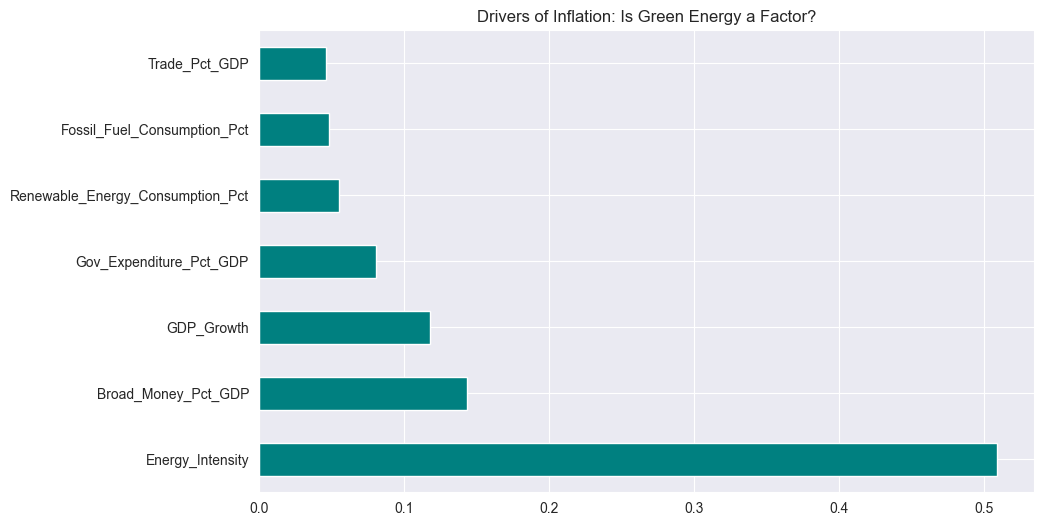

In [21]:
# Goal: Predict Inflation based on Green + Macro vars
target = 'CPI_Inflation'
predictors = [
    'Renewable_Energy_Consumption_Pct', 'Fossil_Fuel_Consumption_Pct',
    'Energy_Intensity', 'Broad_Money_Pct_GDP',
    'GDP_Growth', 'Trade_Pct_GDP', 'Gov_Expenditure_Pct_GDP'
]

X = df[predictors]
y = df[target]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluation
print(f"R2 Score: {r2_score(y_test, rf.predict(X_test)):.3f}")

# Feature Importance Plot
importances = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title('Drivers of Inflation: Is Green Energy a Factor?')
plt.show()

R2 Score: 0.463
MAE (Avg Error): 1.793%


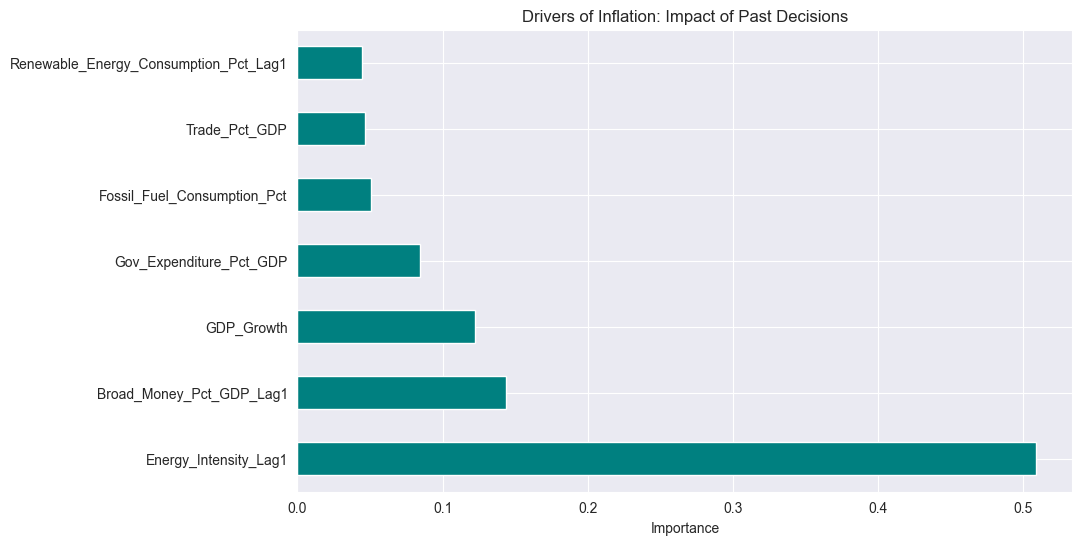

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Goal: Predict Inflation based on Previous Year's Green + Macro vars
target = 'CPI_Inflation'

# UPDATED: Use Lagged variables where available (Scientific best practice)
predictors = [
    'Renewable_Energy_Consumption_Pct_Lag1', # Lagged Green Energy
    'Fossil_Fuel_Consumption_Pct',           # (Keep current if lag doesn't exist)
    'Energy_Intensity_Lag1',                 # Lagged Efficiency
    'Broad_Money_Pct_GDP_Lag1',              # Lagged Money Supply (Crucial for inflation)
    'GDP_Growth',                            # Current growth is okay (often simultaneous)
    'Trade_Pct_GDP',
    'Gov_Expenditure_Pct_GDP'
]

# 1. Drop NaNs specific to these columns to prevent errors
# (Lagged columns often create 1 row of NaNs per country at the start)
data_clean = df.dropna(subset=predictors + [target]).copy()

X = data_clean[predictors]
y = data_clean[target]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluation
y_pred = rf.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE (Avg Error): {mean_absolute_error(y_test, y_pred):.3f}%") # Easier to interpret

# Feature Importance Plot
importances = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title('Drivers of Inflation: Impact of Past Decisions')
plt.xlabel('Importance')
plt.show()

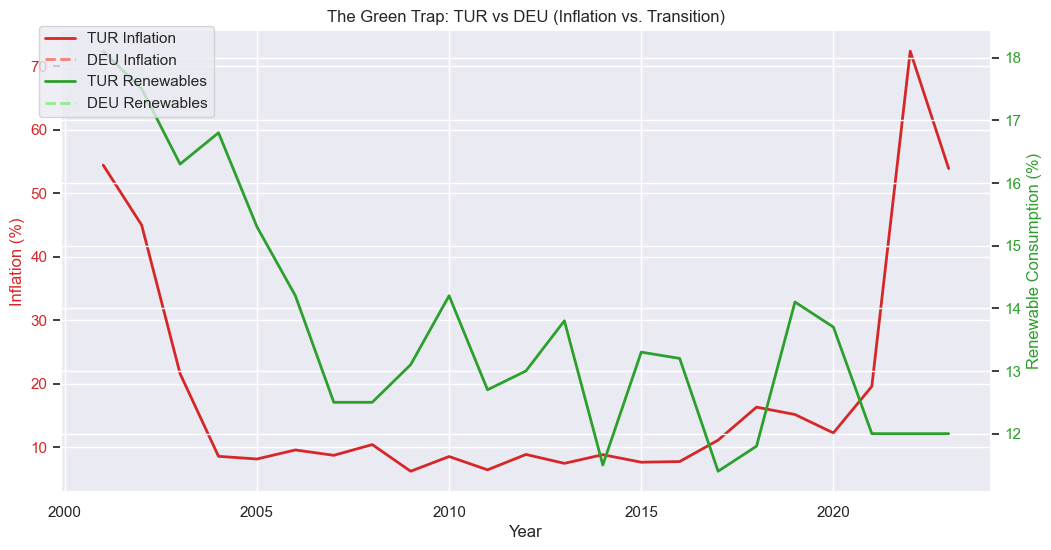

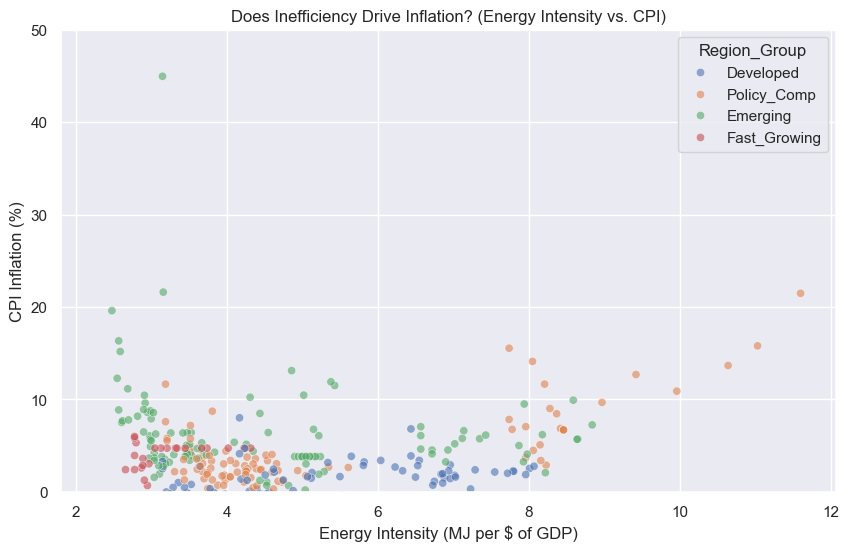

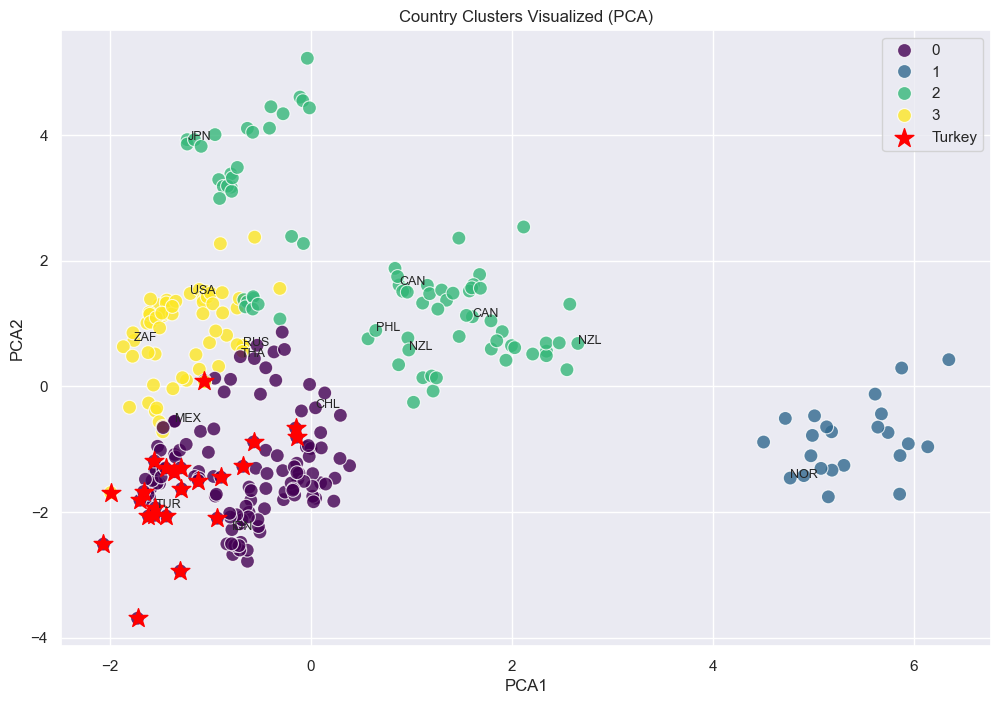

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="darkgrid")

# ==========================================
# 1. TIME SERIES COMPARISON (Turkey vs. Developed Avg)
# ==========================================
# Define a peer group (e.g., 'DEU' for Germany as a benchmark)
target_country = 'TUR'
benchmark_country = 'DEU'

fig, ax1 = plt.subplots(figsize=(12, 6))

# Filter data
tur_data = df[df['Country_Code'] == target_country]
ben_data = df[df['Country_Code'] == benchmark_country]

# Plot Inflation (Lines)
ax1.set_xlabel('Year')
ax1.set_ylabel('Inflation (%)', color='tab:red')
ax1.plot(tur_data['Year'], tur_data['CPI_Inflation'], color='tab:red', linestyle='-', linewidth=2, label=f'{target_country} Inflation')
ax1.plot(ben_data['Year'], ben_data['CPI_Inflation'], color='salmon', linestyle='--', linewidth=2, label=f'{benchmark_country} Inflation')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for Renewables
ax2 = ax1.twinx()
ax2.set_ylabel('Renewable Consumption (%)', color='tab:green')
ax2.plot(tur_data['Year'], tur_data['Renewable_Energy_Consumption_Pct'], color='tab:green', linestyle='-', linewidth=2, label=f'{target_country} Renewables')
ax2.plot(ben_data['Year'], ben_data['Renewable_Energy_Consumption_Pct'], color='lightgreen', linestyle='--', linewidth=2, label=f'{benchmark_country} Renewables')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title(f'The Green Trap: {target_country} vs {benchmark_country} (Inflation vs. Transition)')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()

# ==========================================
# 2. SCATTER: INEFFICIENCY vs. INFLATION
# ==========================================
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Energy_Intensity', y='CPI_Inflation', hue='Region_Group', alpha=0.6)
plt.title('Does Inefficiency Drive Inflation? (Energy Intensity vs. CPI)')
plt.xlabel('Energy Intensity (MJ per $ of GDP)')
plt.ylabel('CPI Inflation (%)')
plt.ylim(0, 50) # Limit y-axis to remove extreme outliers for clarity
plt.show()

# ==========================================
# 3. CLUSTER VISUALIZATION (PCA)
# ==========================================
from sklearn.decomposition import PCA

# Use the same features you used for clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) # Assuming X_scaled is still in memory from your clustering step

# Create a temporary DF for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = df['Cluster'] # Assuming you saved 'Cluster' back to your main df
pca_df['Country'] = df['Country_Code']

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.8)

# Annotate a few key countries to make it readable
for i in range(0, len(pca_df), 20): # Label every 20th point to avoid clutter
    plt.text(pca_df.PCA1.iloc[i], pca_df.PCA2.iloc[i], pca_df.Country.iloc[i], fontsize=9)

# Highlight Turkey specifically
tur_idx = pca_df[pca_df['Country'] == 'TUR'].index
if not tur_idx.empty:
    plt.scatter(pca_df.loc[tur_idx, 'PCA1'], pca_df.loc[tur_idx, 'PCA2'], color='red', s=200, marker='*', label='Turkey')

plt.title('Country Clusters Visualized (PCA)')
plt.legend()
plt.show()

In [28]:
import pandas as pd
from pandas_datareader import wb
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. DOWNLOAD MISSING DATA DIRECTLY
# ==========================================
print("⏳ Downloading fresh data from World Bank for Turkey, Brazil, Germany...")

# Define the indicators we need
indicators = {
    'EG.FEC.RNEW.ZS': 'Renewable_Energy_Consumption_Pct',
    'FP.CPI.TOTL.ZG': 'CPI_Inflation'
}

# Fetch data from 2000 to 2023
try:
    df_fresh = wb.download(
        indicator=list(indicators.keys()),
        country=['TUR', 'BRA', 'DEU'],
        start=2000,
        end=2023
    )
    # Reset index to make Country and Year columns
    df_fresh = df_fresh.reset_index()

    # Rename columns to match your project
    df_fresh = df_fresh.rename(columns=indicators)
    df_fresh = df_fresh.rename(columns={'country': 'Country_Name', 'date': 'Year'})

    # Convert Year to integer
    df_fresh['Year'] = df_fresh['Year'].astype(int)

    # Add ISO Codes manually for clarity
    code_map = {'Turkey': 'TUR', 'Turkiye': 'TUR', 'Brazil': 'BRA', 'Germany': 'DEU'}
    df_fresh['Country_Code'] = df_fresh['Country_Name'].map(code_map)

    print("✅ Download Successful!")

except Exception as e:
    print(f"❌ Download Failed: {e}")
    # Stop if download fails
    raise e

# ==========================================
# 2. PLOT THE PEER COMPARISON
# ==========================================
target_countries = ['TUR', 'BRA', 'DEU']
colors = {'TUR': '#d62728', 'BRA': '#2ca02c', 'DEU': '#1f77b4'} # Red, Green, Blue

fig, ax1 = plt.subplots(figsize=(14, 7))

# --- Left Axis: Renewables (Solid Lines) ---
for country in target_countries:
    subset = df_fresh[df_fresh['Country_Code'] == country].sort_values('Year')
    ax1.plot(subset['Year'], subset['Renewable_Energy_Consumption_Pct'],
             color=colors[country], linestyle='-', linewidth=3, alpha=0.9,
             label=f'{country} Renewable %')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Renewable Consumption (%)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', title="Renewable Share (Solid)")
ax1.grid(True, alpha=0.3)

# --- Right Axis: Inflation (Dashed Lines) ---
ax2 = ax1.twinx()
for country in target_countries:
    subset = df_fresh[df_fresh['Country_Code'] == country].sort_values('Year')
    ax2.plot(subset['Year'], subset['CPI_Inflation'],
             color=colors[country], linestyle='--', linewidth=2, alpha=0.7,
             label=f'{country} Inflation %')

ax2.set_ylabel('CPI Inflation (%)', fontsize=12, fontweight='bold')

# Manual legend for right side
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2, labels2, loc='upper right', title="Inflation (Dashed)")

plt.title('Peer Comparison: Does Green Transition Cause Inflation?', fontsize=14)
plt.show()

⏳ Downloading fresh data from World Bank for Turkey, Brazil, Germany...
❌ Download Failed: 'Year'


KeyError: 'Year'